# Advanced techniques for QAOA

*Usage estimate: 25 minutes on IBM Sherbrooke (NOTE: This is an estimate only. Your runtime may vary.)*



## Background

This notebook introduces advanced techniques to improve the performance of the **Quantum Approximate Optimization Algorithm (QAOA)** with a large number of qubits.
Please see [Solve utility-scale quantum optimization problems](/docs/tutorials/quantum-approximate-optimization-algorithm) for an introduction to QAOA.

The advanced techniques in this notebook include:

*   **SWAP strategy with SAT initial mapping**: This is a specifically designed transpiler pass for QAOA that uses a SWAP strategy and a SAT solver together to improve the selection of which physical qubits on the QPU to use. The SWAP strategy exploits the commutativity of the QAOA operators to reorder gates so that layers of SWAP gates can be simultaneously executed, thus reducing the depth of the circuit [\[1\]](#references). The SAT solver is used to find an initial mapping that minimizes the number of SWAP operations needed to map the qubits in the circuit to the physical qubits on the device [\[2\]](#references) .
*   **CVaR cost function**: Typically the expected value of the cost Hamiltonian is used as the cost function for QAOA, but as was shown in [\[3\]](#references) , focusing on the tail of the distribution, rather than the expected value, can improve the performance of QAOA for combinatorial optimization problems. The CVaR accomplishes this. For a given set of shots with corresponding objective values of the considered optimization problem, the Conditional Value at Risk (CVaR) with confidence level $\alpha \in [0, 1]$ is defined as the average of the $\alpha$ best shots [\[3\]](#references).
    Thus, $\alpha = 1$ corresponds to the standard expected value, while $\alpha=0$ corresponds to the minimum of the given shots, and $\alpha \in (0, 1)$ is a tradeoff between focusing on better shots, while still applying some averaging to smooth out the optimization landscape. Additionally, the CVaR can be used as an error mitigation technique to improve the quality of the objective value estimation [\[4\]](#references).



## Requirements

Before starting this tutorial, be sure you have the following installed:

*   Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
*   Qiskit Runtime v0.22 or later (`pip install qiskit-ibm-runtime`)
*   Rustworkx graph library (`pip install rustworkx`)
*   Python SAT (`pip install python-sat`)



## Setup



In [13]:
from __future__ import annotations

import numpy as np
import rustworkx as rx
from dataclasses import dataclass
from itertools import combinations
from threading import Timer
from IPython.display import Image
from collections.abc import Callable, Iterable
from pysat.formula import CNF, IDPool
from pysat.solvers import Solver
from scipy.optimize import minimize
from rustworkx.visualization import mpl_draw as draw_graph

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler



### Max-Cut Problem

Let's consider solving the **Max-Cut** problem on a graph with 100 nodes using QAOA.
The Max-Cut problem is a combinatorial optimization problem that is defined on a graph $G = (V, E)$, where $V$ is the set of vertices and $E$ is the set of edges. The goal is to partition the vertices into two sets, $S$ and $V \setminus S$, such that the number of edges between the two sets is maximized.
In this example, we use a graph with 100 nodes that is based on a hardware coupling map.






## Step 1: Map classical inputs to a quantum problem

### Graph → Hamiltonian

First, map the problem onto a quantum circuit that is suited for the QAOA. Details on this process can be found in the [introductory QAOA tutorial.](/docs/tutorials/quantum-approximate-optimization-algorithm)

In [ ]:
# Instantiate runtime to access backend
service = QiskitRuntimeService()
backend=service.least_busy(min_num_qubits=100, operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_kingston')>


In [18]:
backend.coupling_map.is_symmetric

True

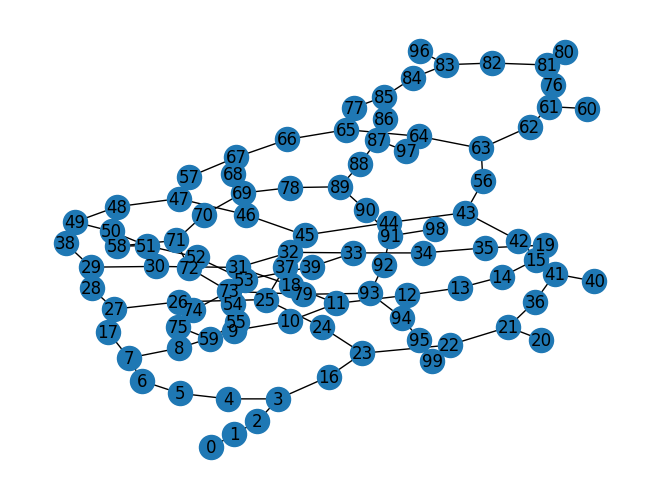

In [17]:
n=100
graph_100 = rx.PyGraph()
graph_100.add_nodes_from((np.arange(0,n,1)))
w=1.0
elist=[]

for edge in backend.coupling_map:
    if (edge[0] <n) and (edge[1] < n):
        if (edge[1] , edge[0], w) not in elist:
            elist.append((edge[0], edge[1], w))

graph_100.add_edges_from(elist)
draw_graph(graph_100, with_labels=True)

In [19]:
# Construct cost hamiltonian 

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph_100)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

## Step 2: Optimize problem for quantum hardware execution

### SWAP strategy with the SAT initial mapping

We will demonstrate how to build and optimize QAOA circuits using the **SWAP strategy with SAT initial mapping**, a specifically designed transpiler pass for QAOA applied to quadratic problems.

In this example, we choose a SWAP insertion strategy for blocks of commuting two-qubit gates, which applies layers of SWAP gates that are simultaneously executable on the coupling map. This strategy is presented in [\[1\]](#references) and is passed into `Commuting2qGateRouter` which is exposed as a standardized Qiskit transpiler pass (see [`Commuting2qGateRouter`](/docs/api/qiskit/qiskit.transpiler.passes.Commuting2qGateRouter)). We use a line swap strategy in this example.



In [20]:
# Extract longest path with no repeated nodes
nodes = rx.longest_simple_path(graph_100)

# Collect even edges and odd edges
even_edges = [
    (nodes[i], nodes[i + 1])
    if nodes[i] < nodes[i + 1]
    else (nodes[i + 1], nodes[i])
    for i in range(0, len(nodes) - 1, 2)
]
odd_edges = [
    (nodes[i], nodes[i + 1])
    if nodes[i] < nodes[i + 1]
    else (nodes[i + 1], nodes[i])
    for i in range(1, len(nodes) - 1, 2)
]
edge_list = [
    (edge[0], edge[1]) if edge[0] < edge[1] else (edge[1], edge[0])
    for edge in graph_100.edge_list()
]

swap_strategy = SwapStrategy(CouplingMap(edge_list), (even_edges, odd_edges))

#### Remap the graph using a SAT mapper

Even when a circuit consists of commuting gates (this is the case for the QAOA circuit, but also for Trotterized simulations of Ising Hamiltonians), finding a good initial mapping is a challenging task. The SAT-based approach presented in [\[2\]](#references) enables the discovery of effective initial mappings for circuits with commuting gates, resulting in a significant reduction in the number of required SWAP layers. This approach has been demonstrated to scale to up to *500 qubits*, as illustrated in the paper.

The following code demonstrates how to use the `SATMapper` from Matsuo et al. to remap the graph. This process allows the problem to be mapped to a more optimal initial state for a specified SWAP strategy, resulting in a significant reduction in the number of SWAP layers required to execute the circuit.

In `SATMapper`, the problem of finding a good initial mapping is formulated as a SAT problem. A SAT solver is used to find such an initial mapping for the QAOA circuit. `python-sat` (`pysat` for short) is a Python library for a SAT solver, and we will use it to solve the SAT problem in this example.



In [21]:
"""A class to solve the SWAP gate insertion initial mapping problem
using the SAT approach from https://arxiv.org/abs/2212.05666.
"""


@dataclass
class SATResult:
    """A data class to hold the result of a SAT solver."""

    satisfiable: bool  # Satisfiable is True if the SAT model could be solved
    # in a given time.
    solution: dict  # The solution to the SAT problem if it is satisfiable.
    mapping: list  # The mapping of nodes in the pattern graph to nodes in the
    # target graph.
    elapsed_time: float  # The time it took to solve the SAT model.


class SATMapper:
    r"""A class to introduce a SAT-approach to solve
    the initial mapping problem in SWAP gate insertion for commuting gates.

    When this pass is run on a DAG it will look for the first instance of
    :class:`.Commuting2qBlock` and use the program graph :math:`P` of this block
    of gates to find a layout for a given swap strategy. This layout is found
    with a binary search over the layers :math:`l` of the swap strategy. At each
    considered layer a subgraph isomorphism problem formulated as a SAT is solved
    by a SAT solver. Each instance is whether it is possible to embed the program
    graph :math:`P` into the effective connectivity graph :math:`C_l` that is
    achieved by applying :math:`l` layers of the swap strategy to the coupling map
    :math:`C_0` of the backend. Since solving SAT problems can be hard, a
    ``time_out`` fixes the maximum time allotted to the SAT solver for each
    instance. If this time is exceeded the considered problem is deemed
    unsatisfiable and the binary search proceeds to the next number of swap
    layers :math:``l``.
    """

    def __init__(self, timeout: int = 60):
        """Initialize the SATMapping.

        Args:
            timeout: The allowed time in seconds for each iteration of the SAT
                solver. This variable defaults to 60 seconds.
        """
        self.timeout = timeout

    def find_initial_mappings(
        self,
        program_graph: rx.Graph,
        swap_strategy: SwapStrategy,
        min_layers: int | None = None,
        max_layers: int | None = None,
    ) -> dict[int, SATResult]:
        r"""Find an initial mapping for a given swap strategy. Perform a
        binary search over the number of swap layers, and for each number
        of swap layers solve a subgraph isomorphism problem formulated as
        a SAT problem.

        Args:
            program_graph (rx.Graph): The program graph with commuting gates, where
                                        each edge represents a two-qubit gate.
            swap_strategy (SwapStrategy): The swap strategy to use to find the
                                        initial mapping.
            min_layers (int): The minimum number of swap layers to consider.
                                        Defaults to the maximum degree of the
                                        program graph - 2.
            max_layers (int): The maximum number of swap layers to consider.
                                        Defaults to the number of qubits in the
                                        swap strategy - 2.

        Returns:
            dict[int, SATResult]: A dictionary containing the results of the SAT
                                    solver for each number of swap layers.
        """
        num_nodes_g1 = len(program_graph.nodes())
        num_nodes_g2 = swap_strategy.distance_matrix.shape[0]
        if num_nodes_g1 > num_nodes_g2:
            return SATResult(False, [], [], 0)
        if min_layers is None:
            # use the maximum degree of the program graph - 2
            # as the lower bound.
            min_layers = max((d for _, d in program_graph.degree)) - 2
        if max_layers is None:
            max_layers = num_nodes_g2 - 1

        variable_pool = IDPool(start_from=1)
        variables = np.array(
            [
                [variable_pool.id(f"v_{i}_{j}") for j in range(num_nodes_g2)]
                for i in range(num_nodes_g1)
            ],
            dtype=int,
        )
        vid2mapping = {v: idx for idx, v in np.ndenumerate(variables)}
        binary_search_results = {}

        def interrupt(solver):
            # This function is called to interrupt the solver when the
            # timeout is reached.
            solver.interrupt()

        # Make a cnf (conjunctive normal form) for the one-to-one
        # mapping constraint
        cnf1 = []
        for i in range(num_nodes_g1):
            clause = variables[i, :].tolist()
            cnf1.append(clause)
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])
        for j in range(num_nodes_g2):
            clause = variables[:, j].tolist()
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])

        # Perform a binary search over the number of swap layers to find the
        # minimum number of swap layers that satisfies the subgraph isomorphism
        # problem.
        while min_layers < max_layers:
            num_layers = (min_layers + max_layers) // 2

            # Create the connectivity matrix. Note that if the swap strategy
            # cannot reach full connectivity then its distance matrix will have
            # entries with -1. These entries must be treated as False.
            d_matrix = swap_strategy.distance_matrix
            connectivity_matrix = (
                (-1 < d_matrix) & (d_matrix <= num_layers)
            ).astype(int)
            # Make a cnf for the adjacency constraint
            cnf2 = []
            for e_0, e_1 in list(program_graph.edge_list()):
                clause_matrix = np.multiply(
                    connectivity_matrix, variables[e_1, :]
                )
                clause = np.concatenate(
                    (
                        [[-variables[e_0, i]] for i in range(num_nodes_g2)],
                        clause_matrix,
                    ),
                    axis=1,
                )
                # Remove 0s from each clause
                cnf2.extend([c[c != 0].tolist() for c in clause])

            cnf = CNF(from_clauses=cnf1 + cnf2)

            with Solver(bootstrap_with=cnf, use_timer=True) as solver:
                # Solve the SAT problem with a timeout.
                # Timer is used to interrupt the solver when the
                # timeout is reached.
                timer = Timer(self.timeout, interrupt, [solver])
                timer.start()
                status = solver.solve_limited(expect_interrupt=True)
                timer.cancel()
                # Get the solution and the elapsed time.
                sol = solver.get_model()
                e_time = solver.time()

                print(
                    f"Layers: {num_layers}, Status: {status}, Time: {e_time}"
                )
                if status:
                    # If the SAT problem is satisfiable, convert the solution
                    # to a mapping.
                    mapping = [vid2mapping[idx] for idx in sol if idx > 0]
                    binary_search_results[num_layers] = SATResult(
                        status, sol, mapping, e_time
                    )
                    max_layers = num_layers
                else:
                    # If the SAT problem is unsatisfiable, return the last
                    # satisfiable solution.
                    binary_search_results[num_layers] = SATResult(
                        status, sol, [], e_time
                    )
                    min_layers = num_layers + 1

        return binary_search_results

    def remap_graph_with_sat(
        self, graph: rx.Graph, swap_strategy, max_layers
    ):
        """Applies the SAT mapping.

        Args:
            graph (nx.Graph): The graph to remap.
            swap_strategy (SwapStrategy): The swap strategy to use
                                            to find the initial mapping.

        Returns:
            tuple: A tuple containing the remapped graph, the edge map, and the
            number of layers of the swap strategy that was used to find the
            initial mapping. If no solution is found then the tuple contains
            None for each element. Note the returned edge map `{k: v}` means that
            node `k` in the original graph gets mapped to node `v` in the
            Pauli strings.
        """
        num_nodes = len(graph.nodes())
        results = self.find_initial_mappings(
            graph, swap_strategy, 0, max_layers
        )
        solutions = [k for k, v in results.items() if v.satisfiable]

        if len(solutions):
            min_k = min(solutions)
            edge_map = dict(results[min_k].mapping)
            # Create the remapped graph
            remapped_graph = rx.PyGraph()
            remapped_graph.add_nodes_from(range(num_nodes))
            mapping = dict(results[min_k].mapping)
            for i, graph_edge in enumerate(list(graph.edge_list())):
                remapped_edge = tuple(mapping[node] for node in graph_edge)
                remapped_graph.add_edge(*remapped_edge, graph.edges()[i])
            return remapped_graph, edge_map, min_k
        else:
            return None, None, None

Layers: 0, Status: True, Time: 0.02229800000000015
Map from old to new nodes:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99}
Min SWAP layers: 0


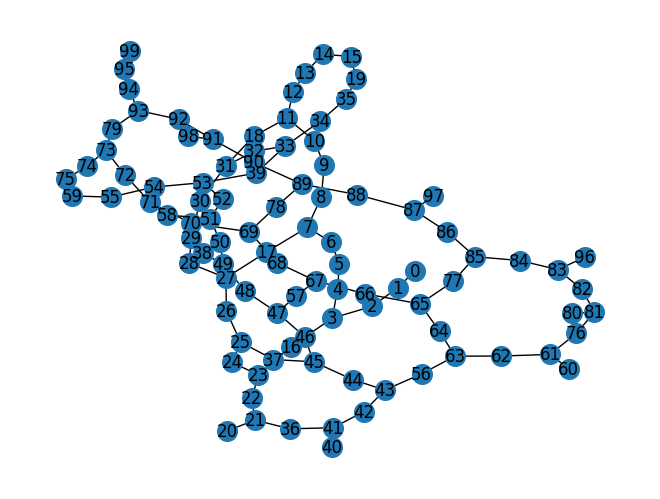

In [22]:
sm = SATMapper(timeout=10)
remapped_graph, edge_map, min_swap_layers = sm.remap_graph_with_sat(
    graph=graph_100, swap_strategy=swap_strategy, max_layers=1
)
print("Map from old to new nodes: ", edge_map)
print("Min SWAP layers:", min_swap_layers)
draw_graph(remapped_graph, node_size=200, with_labels=True, width=1)

In [23]:
remapped_max_cut_paulis = build_max_cut_paulis(remapped_graph)
# define a qiskit SparsePauliOp from the list of paulis
remapped_cost_operator = SparsePauliOp.from_list(remapped_max_cut_paulis)
print(remapped_cost_operator)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

#### Build a QAOA circuit with the SWAP strategy and the SAT mapping

We only want to apply the SWAP strategies to the cost operator layer, so we start by creating the isolated block that we will later transform and append to the final QAOA circuit.

For this, we can use the [`QAOAAnsatz`](/docs/api/qiskit/qiskit.circuit.library.QAOAAnsatz) class from Qiskit. We input an empty circuit to the `initial_state` and `mixer_operator` fields to make sure we are building an isolated cost operator layer.
We also define the edge\_coloring map so that RZZ gates are positioned next to SWAP gates. This strategic placement allows us to exploit CX cancellations, optimizing the circuit for better performance.
This process is executed within the `create_qaoa_swap_circuit` function.



In [24]:
def make_meas_map(circuit: QuantumCircuit) -> dict:
    """Return a mapping from qubit index (the key) to classical bit (the value).

    This allows us to account for the swapping order introduced by the SWAP strategy.
    """
    creg = circuit.cregs[0]
    qreg = circuit.qregs[0]

    meas_map = {}
    for inst in circuit.data:
        if inst.operation.name == "measure":
            meas_map[qreg.index(inst.qubits[0])] = creg.index(inst.clbits[0])

    return meas_map


def apply_swap_strategy(
    circuit: QuantumCircuit,
    swap_strategy: SwapStrategy,
    edge_coloring: dict[tuple[int, int], int] | None = None,
) -> QuantumCircuit:
    """Transpile with a SWAP strategy.

    Returns:
        A quantum circuit transpiled with the given swap strategy.
    """

    pm_pre = PassManager(
        [
            FindCommutingPauliEvolutions(),
            Commuting2qGateRouter(
                swap_strategy,
                edge_coloring,
            ),
        ]
    )
    return pm_pre.run(circuit)


def apply_qaoa_layers(
    cost_layer: QuantumCircuit,
    meas_map: dict,
    num_layers: int,
    gamma: list[float] | ParameterVector = None,
    beta: list[float] | ParameterVector = None,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Applies QAOA layers to construct circuit.

    First, the initial state is applied. If `initial_state` is None, we begin in the
    initial superposition state. Next, we alternate between layers of the cost operator
    and the mixer. The cost operator is alternatively applied in order and in reverse
    instruction order. This allows us to apply the swap strategy on odd `p` layers
    and undo the swap strategy on even `p` layers.
    """

    num_qubits = cost_layer.num_qubits
    new_circuit = QuantumCircuit(num_qubits, num_qubits)

    if initial_state is not None:
        new_circuit.append(initial_state, range(num_qubits))
    else:
        # all h state by default
        new_circuit.h(range(num_qubits))

    if gamma is None or beta is None:
        gamma = ParameterVector("γ'", num_layers)
        if mixer is None or mixer.num_parameters == 0:
            beta = ParameterVector("β'", num_layers)
        else:
            beta = ParameterVector("β'", num_layers * mixer.num_parameters)

    if mixer is not None:
        mixer_layer = mixer
    else:
        mixer_layer = QuantumCircuit(num_qubits)
        mixer_layer.rx(-2 * beta[0], range(num_qubits))

    for layer in range(num_layers):
        bind_dict = {cost_layer.parameters[0]: gamma[layer]}
        cost_layer_ = cost_layer.assign_parameters(bind_dict)
        bind_dict = {
            mixer_layer.parameters[i]: beta[layer + i]
            for i in range(mixer_layer.num_parameters)
        }
        layer_mixer = mixer_layer.assign_parameters(bind_dict)

        if layer % 2 == 0:
            new_circuit.append(cost_layer_, range(num_qubits))
        else:
            new_circuit.append(cost_layer_.reverse_ops(), range(num_qubits))

        new_circuit.append(layer_mixer, range(num_qubits))

    for qidx, cidx in meas_map.items():
        new_circuit.measure(qidx, cidx)

    return new_circuit


def create_qaoa_swap_circuit(
    cost_operator: SparsePauliOp,
    swap_strategy: SwapStrategy,
    edge_coloring: dict = None,
    theta: list[float] = None,
    qaoa_layers: int = 1,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Create the circuit for QAOA.

    Notes: This circuit construction for QAOA works for quadratic terms in `Z` and will be
    extended to first-order terms in `Z`. Higher-orders are not supported.

    Args:
        cost_operator: the cost operator.
        swap_strategy: selected swap strategy
        edge_coloring: A coloring of edges that should correspond to the coupling
            map of the hardware. It defines the order in which we apply the Rzz
            gates. This allows us to choose an ordering such that `Rzz` gates will
            immediately precede SWAP gates to leverage CNOT cancellation.
        theta: The QAOA angles.
        qaoa_layers: The number of layers of the cost operator and the mixer operator.
        initial_state: The initial state on which we apply layers of cost operator
            and mixer.
        mixer: The QAOA mixer. It will be applied as is onto the QAOA circuit. Therefore,
            its output must have the same ordering of qubits as its input.
    """

    num_qubits = cost_operator.num_qubits

    if theta is not None:
        gamma = theta[: len(theta) // 2]
        beta = theta[len(theta) // 2 :]
        qaoa_layers = len(theta) // 2
    else:
        gamma = beta = None

    # First, create the ansatz of 1 layer of QAOA without mixer
    cost_layer = QAOAAnsatz(
        cost_operator,
        reps=1,
        initial_state=QuantumCircuit(num_qubits),
        mixer_operator=QuantumCircuit(num_qubits),
    ).decompose()

    # This will allow us to recover the permutation of the measurements that the swaps introduce.
    cost_layer.measure_all()

    # Now, apply the swap strategy for commuting gates
    cost_layer = apply_swap_strategy(cost_layer, swap_strategy, edge_coloring)

    # Compute the measurement map (qubit to classical bit).
    # We will apply this for odd layers where the swaps were inserted.
    if qaoa_layers % 2 == 1:
        meas_map = make_meas_map(cost_layer)
    else:
        meas_map = {idx: idx for idx in range(num_qubits)}

    cost_layer.remove_final_measurements()

    # Finally, introduce the mixer circuit and add measurements following measurement map
    circuit = apply_qaoa_layers(
        cost_layer, meas_map, qaoa_layers, gamma, beta, initial_state, mixer
    )

    return circuit

In [25]:
# We can define the edge_coloring map so that RZZ gates are positioned right before SWAP gates to exploit CX cancellations
# We use greedy edge coloring from rustworkx to color the edges of the graph. This coloring is used to order the RZZ gates in the circuit.

edge_coloring_idx = rx.graph_greedy_edge_color(graph_100)
edge_coloring = {
    edge: edge_coloring_idx[idx]
    for idx, edge in enumerate(list(graph_100.edge_list()))
}
edge_coloring = {tuple(sorted(k)): v for k, v in edge_coloring.items()}

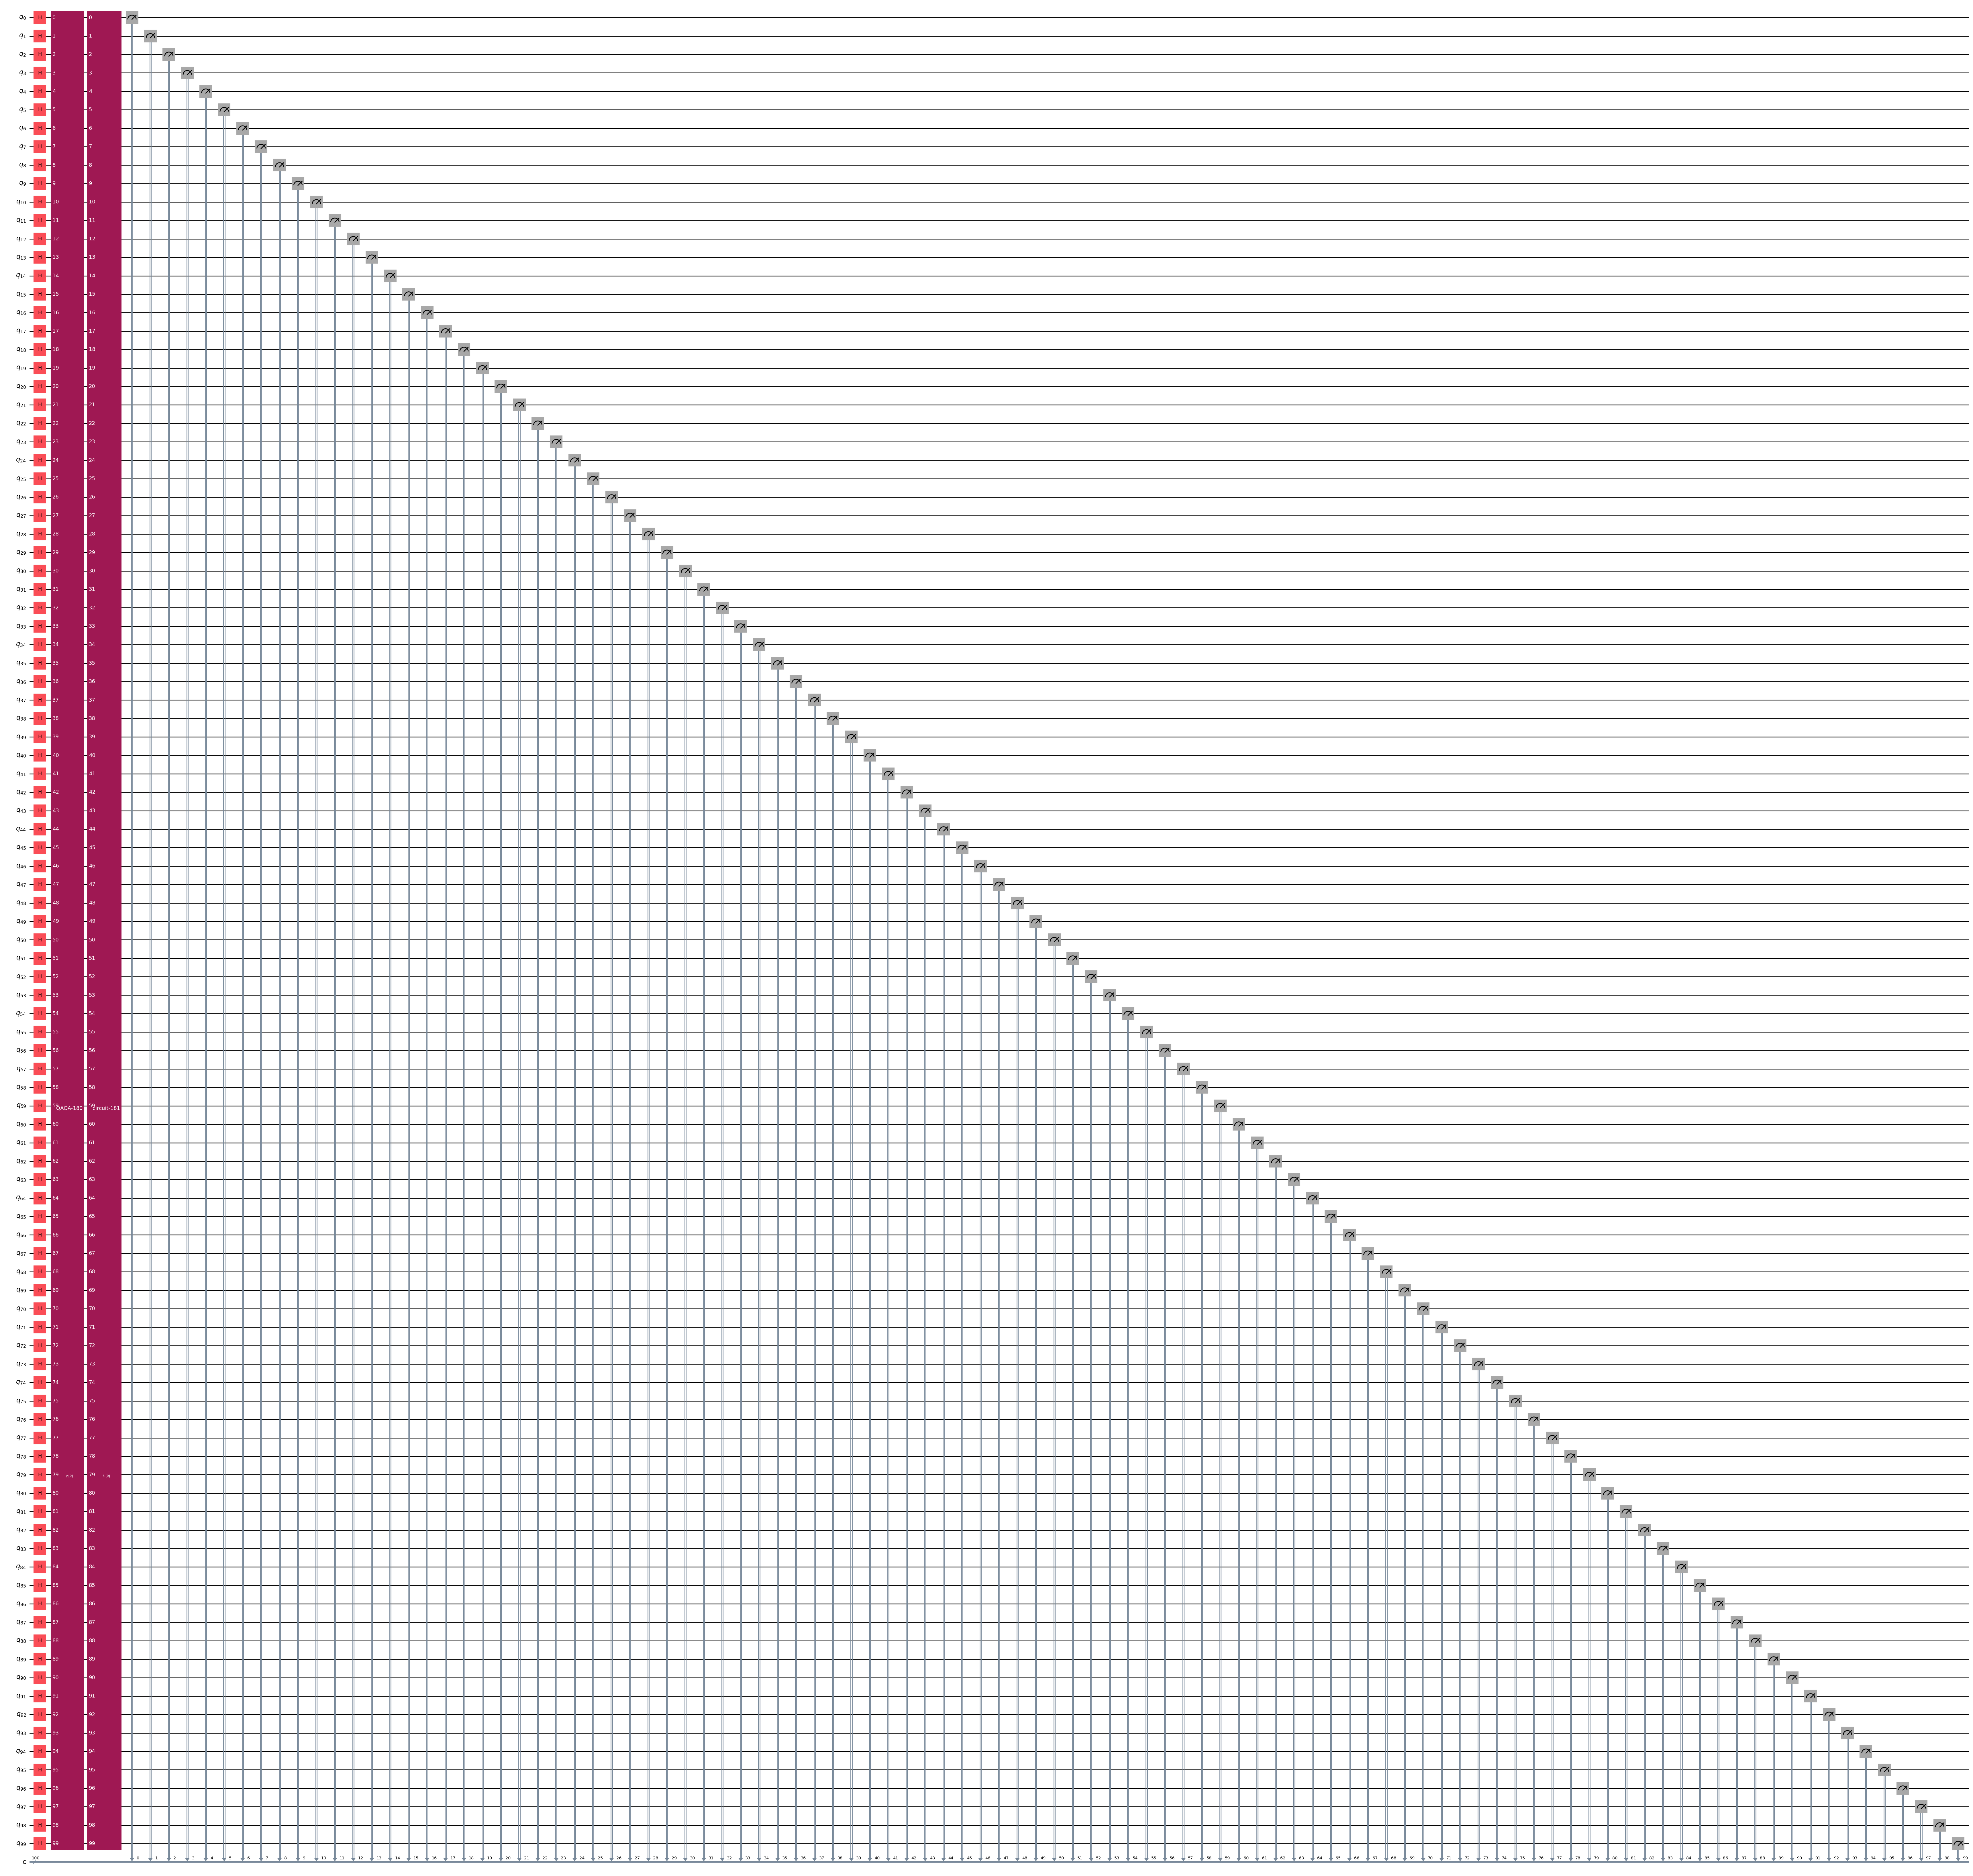

In [26]:
qaoa_circ = create_qaoa_swap_circuit(
    remapped_cost_operator,
    swap_strategy,
    edge_coloring=edge_coloring,
    qaoa_layers=1,
)
qaoa_circ.draw(output="mpl", fold=False)

## Step 3: Execute using Qiskit primitives

### Define a CVaR cost function

This example shows how to use the Conditional Value at Risk (CVaR) cost function introduced in [\[3\]](#references) within the variational quantum optimization algorithms.

The CVaR of a random variable $X$ for a confidence level $α ∈ (0, 1]$ is defined as
$CVaR_{\alpha}(X) = \mathbb{E} \lbrack X | X \leq F_X^{-1}(\alpha) \rbrack$
where $F_X^{-1}(p)$ is the inverse cumulative distribution function of $X$. In other words, CVaR is the expected value of the lower $\alpha$-tail of the distribution of $X$.



In [27]:
# Write (causes no increase in depth, just increases number of qubits to number of qubits on device)

pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
)
 
transpiled_qaoa_circ = pass_manager.run(qaoa_circ)

In [28]:
# Utility functions for the evaluation of the expectation value of a measured state
# In this code, for optimization, the measured state is converted into a bit string,
# and the sign of the value is determined by taking the exclusive OR of the bits
# corresponding to Pauli Z.

_PARITY = np.array(
    [-1 if bin(i).count("1") % 2 else 1 for i in range(256)],
    dtype=np.complex128,
)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state.

    Args:
        state (int): The measured state.
        observable (SparsePauliOp): The observable to evaluate the expectation value for.

    Returns:
        complex: The expectation value of the measured state.
    """
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little") # convert observable to array with 8 bit integer
    state_bytes = np.frombuffer(
        state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8 # convert bistring to array with 8 bit integer
    )
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1) # take bitwise xor of the result of 'and' conditional on the above two, return 0 or 1
    return np.sum(observable.coeffs * _PARITY[reduced])

In [29]:
def qaoa_sampler_cost_fun(
    params, ansatz, hamiltonian, sampler, aggregation=None
):
    """Standard sampler-based QAOA cost function to be plugged into optimizer routines.

    Args:
        params (np.ndarray): Parameters for the ansatz.
        ansatz (QuantumCircuit): Ansatz circuit.
        hamiltonian (SparsePauliOp): Hamiltonian to be minimized.
        sampler (QAOASampler): Sampler to be used.
        aggregation (Callable | float | None): Aggregation function to be applied to
            the sampled results. If None, the sum of the expectation values is returned.
            If float, the CVaR with the given alpha is used.
    """
    # Run the circuit
    job = sampler.run([(ansatz, params)])
    sampler_result = job.result()
    sampled_int_counts = sampler_result[0].data.c.get_int_counts() # bitstrings are stored as integers
    shots = sum(sampled_int_counts.values())
    int_count_distribution = {
        key: val / shots for key, val in sampled_int_counts.items()
    }

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (
            probability,
            np.real(evaluate_sparse_pauli(state, hamiltonian)),
        )
        for state, probability in int_count_distribution.items()
    }

    # If aggregation is None, return the sum of the expectation values.
    # If aggregation is a float, return the CVaR with the given alpha.
    # Otherwise, use the aggregation function.
    if aggregation is None:
        result = sum(
            probability * value for probability, value in evaluated.values()
        )
    elif isinstance(aggregation, float):
        cvar_aggregation = _get_cvar_aggregation(aggregation)
        result = cvar_aggregation(evaluated.values())
    else:
        result = aggregation(evaluated.values())

    global iter_counts, result_dict
    iter_counts += 1
    temp_dict = {}
    temp_dict["params"] = params.tolist()
    temp_dict["cvar_fval"] = result
    temp_dict["fval"] = sum(
        probability * value for probability, value in evaluated.values()
    )
    temp_dict["distribution"] = sampled_int_counts
    temp_dict["evaluated"] = evaluated
    result_dict[iter_counts] = temp_dict
    print(f"Iteration {iter_counts}: {result}")

    return result


def _get_cvar_aggregation(alpha: float | None) -> Callable:
    """Return the CVaR aggregation function with the given alpha.

    Args:
        alpha (float | None): Alpha value for the CVaR aggregation. If None, 1 is used
            by default.
    Raises:
        ValueError: If alpha is not in [0, 1].
    """
    if alpha is None:
        alpha = 1
    elif not 0 <= alpha <= 1:
        raise ValueError(f"alpha must be in [0, 1], but {alpha} was given.")


    def cvar_aggregation(
        objective_dict: Iterable[tuple[float, float]],
    ) -> float:
        """Return the CVaR of the given measurements.
        Args:
            objective_dict (Iterable[tuple[float, float]]): An iterable of tuples containing
                the measured bit string and the objective value based on the bit string.

        """
        sorted_measurements = sorted(objective_dict, key=lambda x: x[1])
        # accumulate the probabilities until alpha is reached
        accumulated_percent = 0.0
        cvar = 0.0
        for probability, value in sorted_measurements:
            cvar += value * min(probability, alpha - accumulated_percent)
            accumulated_percent += probability
            if accumulated_percent >= alpha:
                break
        return cvar / alpha

    return cvar_aggregation

The CVaR can be used as an error mitigation technique as previously discussed [\[4\]](#references). In this example, we determine $\alpha$ and the number of shots according to the circuit's error rate.



In [30]:
num_2q_ops = transpiled_qaoa_circ.count_ops()["cz"] # the two qubit gates on our backend are cz's.

for el in backend.properties().general:
    if el.name[:2] == "lf" and el.name[3:] == str(n): # pick out lf_100, lf of the best 100q chain
        lf = el.value  # layer fidelity
        print("layer fidelity", lf)
        eplg = 1 - lf ** (1 / (n - 1))  # error per layered gate (EPLG)
        fid_cz = 1 - eplg
        gamma_cz = 1 / fid_cz**2
        gamma_circ = gamma_cz ** num_2q_ops

cvar_aggregation = 1 / np.sqrt(gamma_circ)
print("")
print("The corresponding CVaR aggregation value is: ", cvar_aggregation)
print(
    "To mitigate the twirled noise, increase shots by a factor of", np.sqrt(gamma_circ)
)

layer fidelity 0.6544189744623636

The corresponding CVaR aggregation value is:  0.38642994025160377
To mitigate the twirled noise, increase shots by a factor of 2.5877912031063173


In [86]:
iter_counts = 0
result_dict={}
init_params=[np.pi, np.pi/2]

with Session(backend=backend) as session:
    sampler=Sampler(mode=session)
    sampler.options.default_shots = int(1000/cvar_aggregation)
    sampler.options.dynamical_decoupling.enable=True
    sampler.options.dynamical_decoupling.sequence_type='XY4'
    sampler.options.twirling.enable_gates=True
    sampler.options.twirling.enable_measure=True

    result = minimize(qaoa_sampler_cost_fun,
                  init_params,
                  args= (transpiled_qaoa_circ,
                         remapped_cost_operator,
                         sampler,
                         cvar_aggregation
                         ),
                method='COBYLA',
                tol=1e-2)
print(result)

Iteration 1: -10.010143313246703
Iteration 2: -10.778378196890142
Iteration 3: -33.11648157016098
Iteration 4: 23.37766951385026
Iteration 5: -8.456279717029192
Iteration 6: -20.250216714385534
Iteration 7: -45.87610233094513
Iteration 8: -20.4522784936772
Iteration 9: -49.63202770645467
Iteration 10: -49.10586683562599
Iteration 11: -49.15188090417742
Iteration 12: -45.84209193245048
Iteration 13: -49.634028318131016
Iteration 14: -48.542306019104984
Iteration 15: -49.8580968258604
Iteration 16: -49.7000485034442
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -49.8580968258604
       x: [ 4.262e+00  2.820e+00]
    nfev: 16
   maxcv: 0.0


## Step 4: Post-process and return result in desired classical format



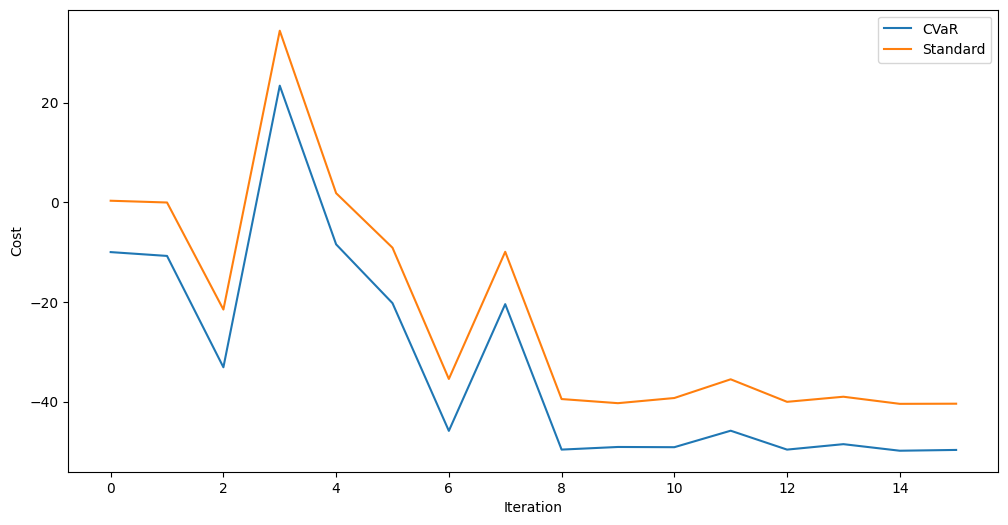

In [100]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    [result_dict[i]["cvar_fval"] for i in range(1, iter_counts + 1)],
    label="CVaR",
)
plt.plot(
    [result_dict[i]["fval"] for i in range(1, iter_counts + 1)],
    label="Standard",
)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

The following retrieves the best solution from the sampled bitstrings



In [101]:
# sort the result_dict[iter_counts]['evaluated] by the CVaR value
sorted_result_dict = [
    (k, v)
    for k, v in sorted(
        result_dict[iter_counts]["evaluated"].items(),
        key=lambda item: item[1][1],
    )
]
print(
    f"bitstring (int): {sorted_result_dict[0][0]}, probability: {sorted_result_dict[0][1][0]}, objective value: {sorted_result_dict[0][1][1]}"
)

bitstring (int): 1056839274160662489278455764297, probability: 0.00038654812524159255, objective value: -71.0


Consider the Hamiltonian $H_C$ for the **Max-Cut** problem. Let each vertex of the graph be associated with a qubit in state $|0\rangle$ or $|1\rangle$, where the value denotes the set the vertex is in. The goal of the problem is to maximize the number of edges $(v_1, v_2)$ for which $v_1 = |0\rangle$ and $v_2 = |1\rangle$, or vice-versa. If we associate the $Z$ operator with each qubit, where

$$
    Z|0\rangle = |0\rangle \qquad Z|1\rangle = -|1\rangle
$$

then an edge $(v_1, v_2)$ belongs to the cut if the eigenvalue of $(Z_1|v_1\rangle) \cdot (Z_2|v_2\rangle) = -1$; in other words, the qubits associated with $v_1$ and $v_2$ are different. Similarly, $(v_1, v_2)$ does not belong to the cut if the eigenvalue of $(Z_1|v_1\rangle) \cdot (Z_2|v_2\rangle) = 1$

In [102]:
from typing import Sequence

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u]) # x[u] = x[v] if same cut, x[u] \neq x[v] if different cuts
        for u, v in list(graph.edge_list())
    )


bitstring = to_bitstring(
    sorted_result_dict[0][0], len(list(remapped_graph.nodes()))
)
bitstring = bitstring[::-1]
print(f"Result bitstring (binary) : {bitstring}")

cut_value = evaluate_sample(bitstring, remapped_graph)
print(f"The value of the cut is: {cut_value}")

Result bitstring (binary) : [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
The value of the cut is: 91


Finally, let's draw a graph based on the CVaR result.
We split the graph nodes into two sets based on the CVaR result.
The nodes in the first set are colored in gray, and the nodes in the second set are colored in purple.
The edges between the two sets are the edges that are cut by the partitioning.



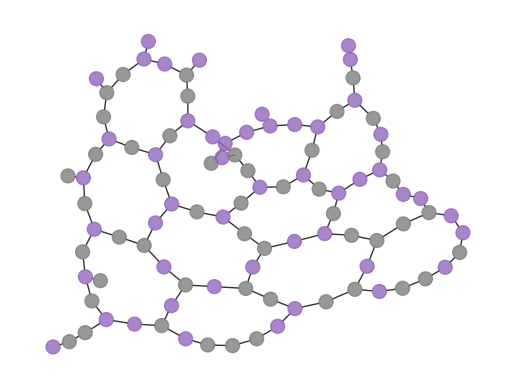

In [103]:
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=100, alpha=0.8, pos=pos
    )


plot_result(graph_100, to_bitstring(sorted_result_dict[0][0], 100))

## References

\[1] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870.

\[2] Matsuo, A., Yamashita, S., & Egger, D. J. (2023). A SAT approach to the initial mapping problem in SWAP gate insertion for commuting gates. IEICE Transactions on Fundamentals of Electronics, Communications and Computer Sciences, 106(11), 1424-1431.

\[3] Barkoutsos, P. K., Nannicini, G., Robert, A., Tavernelli, I., & Woerner, S. (2020). Improving variational quantum optimization using CVaR. Quantum, 4, 256.

\[4] Barron, S. V., Egger, D. J., Pelofske, E., Bärtschi, A., Eidenbenz, S., Lehmkuehler, M., & Woerner, S. (2023). Provable bounds for noise-free expectation values computed from noisy samples. arXiv preprint arXiv:2312.00733.



## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_cZwpScxyXVDpIeq)



© IBM Corp. 2025



© IBM Corp., 2017-2025